# BNPL Stock Performance vs Interest Rates

## Multi-Factor Regression Analysis: BNPL Sensitivity to Interest Rates

**Research Question:** Are BNPL firms more sensitive to interest rate changes than the broader market, after controlling for market movements and other factors?

**Method:**
- **Data Sources**: FRED API (interest rates), Yahoo Finance (stock prices, market indices, volatility)
- **Models**: 
  1. **Simple Model**: BNPL Returns ~ Interest Rate Changes
  2. **Multi-Factor Model**: BNPL Returns ~ Interest Rate Changes + Market Returns + Volatility + Controls

**Why Multi-Factor Model?**
- Single-factor models miss important controls (market movements, volatility, etc.)
- Need to control for market-wide effects to isolate BNPL-specific sensitivity
- More robust and appropriate for academic research

**Expected Result:** BNPL stocks should be **negatively** correlated with interest rates, even after controlling for market movements (rates ↑ → BNPL stocks ↓ more than market)

---


In [430]:
# Install required packages if needed
import subprocess
import sys

try:
    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pandas_datareader import data as web
    import statsmodels.api as sm
    print("✓ All packages available")
except ImportError as e:
    print(f"Installing missing packages: {e}")
    packages = ['yfinance', 'pandas-datareader', 'statsmodels', 'seaborn']
    for pkg in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pandas_datareader import data as web
    import statsmodels.api as sm
    print("✓ Installation complete")

# ============================================================================
# CONFIGURE PUBLICATION-QUALITY PLOTTING STYLE
# ============================================================================
# Professional academic/economics journal style
plt.style.use('seaborn-v0_8-whitegrid')  # Clean background with subtle grid
sns.set_palette("husl")  # Professional color palette

# Set publication-quality parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'axes.linewidth': 1.2,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'legend.framealpha': 0.9,
    'figure.titlesize': 14,
    'figure.titleweight': 'bold',
    'grid.linewidth': 0.8,
    'grid.alpha': 0.3,
    'lines.linewidth': 2.5,
    'lines.markersize': 8,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white',
    'savefig.edgecolor': 'none',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

print("\n✓ Publication-quality plotting style configured")
print("  - Professional color scheme")
print("  - Clear labels and titles")
print("  - High-resolution output (300 DPI)")


✓ All packages available

✓ Publication-quality plotting style configured
  - Professional color scheme
  - Clear labels and titles
  - High-resolution output (300 DPI)


In [431]:
# ============================================================================
# STEP 1: GET INTEREST RATE DATA FROM FRED
# ============================================================================

print("=" * 80)
print("STEP 1: COLLECTING INTEREST RATE DATA (FRED)")
print("=" * 80)

# FRED API - No key needed for basic data, but you can get free key at https://fred.stlouisfed.org/
# Federal Funds Rate (FEDFUNDS) - primary interest rate
# 10-Year Treasury Rate (DGS10) - long-term rates

start_date = '2020-01-01'  # Start from 2020 to capture recent BNPL growth
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

print(f"\nDate range: {start_date} to {end_date}")
print("\nFetching interest rate data from FRED...")

try:
    # Federal Funds Rate (daily)
    fed_funds = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
    fed_funds.columns = ['fed_funds_rate']
    
    # 10-Year Treasury Rate (daily)
    treasury_10y = web.DataReader('DGS10', 'fred', start_date, end_date)
    treasury_10y.columns = ['treasury_10y']
    
    # Unemployment Rate (monthly) - for multi-factor model
    try:
        unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date)
        unemployment.columns = ['unemployment_rate']
        print(f"✓ Unemployment Rate: {len(unemployment)} observations")
    except:
        print("⚠ Unemployment Rate not available")
        unemployment = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='ME'))
        unemployment['unemployment_rate'] = np.nan
    
    # Real GDP Growth (quarterly, converted to monthly) - for multi-factor model
    try:
        gdp = web.DataReader('GDPC1', 'fred', start_date, end_date)  # Real GDP, Seasonally Adjusted
        gdp.columns = ['real_gdp']
        print(f"✓ Real GDP: {len(gdp)} observations")
    except:
        print("⚠ Real GDP not available")
        gdp = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='ME'))
        gdp['real_gdp'] = np.nan
    
    # National Debt (monthly) - Federal Debt: Total Public Debt
    try:
        national_debt = web.DataReader('GFDEBTN', 'fred', start_date, end_date)
        national_debt.columns = ['national_debt']
        print(f"✓ National Debt: {len(national_debt)} observations")
    except:
        print("⚠ National Debt not available")
        national_debt = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='ME'))
        national_debt['national_debt'] = np.nan
    
    # Inflation (monthly) - Consumer Price Index for All Urban Consumers
    try:
        cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
        cpi.columns = ['cpi']
        print(f"✓ CPI (Inflation): {len(cpi)} observations")
    except:
        print("⚠ CPI not available")
        cpi = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='ME'))
        cpi['cpi'] = np.nan
    
    print(f"✓ Federal Funds Rate: {len(fed_funds)} observations")
    print(f"✓ 10-Year Treasury: {len(treasury_10y)} observations")
    
    # Merge rates
    rates = pd.concat([fed_funds, treasury_10y], axis=1)
    rates = rates.dropna()
    
    # Calculate monthly averages for easier analysis
    rates_monthly = rates.resample('ME').mean()  # ME = Month End (replaces deprecated 'M')
    
    # Merge unemployment (already monthly)
    if not unemployment.empty:
        unemployment_monthly = unemployment.resample('ME').last()
        rates_monthly = rates_monthly.join(unemployment_monthly, how='outer')
    
    # Merge GDP (quarterly, forward-fill to monthly)
    if not gdp.empty:
        gdp_monthly = gdp.resample('ME').last().ffill()
        rates_monthly = rates_monthly.join(gdp_monthly, how='outer')
    
    # Merge national debt (monthly)
    if not national_debt.empty:
        national_debt_monthly = national_debt.resample('ME').last()
        rates_monthly = rates_monthly.join(national_debt_monthly, how='outer')
    
    # Merge CPI/inflation (monthly)
    if not cpi.empty:
        cpi_monthly = cpi.resample('ME').last()
        rates_monthly = rates_monthly.join(cpi_monthly, how='outer')
    
    # Calculate rate changes (month-over-month)
    rates_monthly['fed_funds_change'] = rates_monthly['fed_funds_rate'].diff()
    rates_monthly['treasury_10y_change'] = rates_monthly['treasury_10y'].diff()
    
    # Calculate unemployment rate change
    if 'unemployment_rate' in rates_monthly.columns:
        rates_monthly['unemployment_change'] = rates_monthly['unemployment_rate'].diff()
    
    # Calculate GDP growth rate (quarter-over-quarter, converted to monthly proxy)
    if 'real_gdp' in rates_monthly.columns:
        rates_monthly['gdp_growth'] = rates_monthly['real_gdp'].pct_change() * 100  # Percentage change
    
    # Calculate national debt change (month-over-month percentage)
    if 'national_debt' in rates_monthly.columns:
        rates_monthly['national_debt_change'] = rates_monthly['national_debt'].pct_change() * 100
    
    # Calculate inflation rate (month-over-month CPI change)
    if 'cpi' in rates_monthly.columns:
        rates_monthly['inflation_rate'] = rates_monthly['cpi'].pct_change() * 100
    
    print(f"\n✓ Monthly data: {len(rates_monthly)} months")
    print(f"\nInterest Rate Statistics:")
    print(rates_monthly[['fed_funds_rate', 'treasury_10y']].describe())
    
except Exception as e:
    print(f"⚠ Error fetching FRED data: {e}")
    print("Note: FRED API may require internet connection. Using placeholder data.")
    # Create placeholder data
    dates = pd.date_range(start=start_date, end=end_date, freq='ME')  # ME = Month End
    rates_monthly = pd.DataFrame({
        'fed_funds_rate': np.random.uniform(0.5, 5.5, len(dates)),
        'treasury_10y': np.random.uniform(1.5, 4.5, len(dates)),
    }, index=dates)
    rates_monthly['fed_funds_change'] = rates_monthly['fed_funds_rate'].diff()
    rates_monthly['treasury_10y_change'] = rates_monthly['treasury_10y'].diff()


STEP 1: COLLECTING INTEREST RATE DATA (FRED)

Date range: 2020-01-01 to 2025-11-03

Fetching interest rate data from FRED...
✓ Unemployment Rate: 68 observations
✓ Real GDP: 22 observations
✓ National Debt: 22 observations
✓ CPI (Inflation): 69 observations
✓ Federal Funds Rate: 70 observations
✓ 10-Year Treasury: 1523 observations

✓ Monthly data: 70 months

Interest Rate Statistics:
       fed_funds_rate  treasury_10y
count       46.000000     46.000000
mean         2.631957      2.818913
std          2.326477      1.420833
min          0.050000      0.620000
25%          0.082500      1.480000
50%          3.170000      3.325000
75%          5.002500      4.157500
max          5.330000      4.770000


/var/folders/vk/b6wqznms0035nb3gx2sxcfqr0000gn/T/ipykernel_40122/968593478.py:108: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rates_monthly['gdp_growth'] = rates_monthly['real_gdp'].pct_change() * 100  # Percentage change
/var/folders/vk/b6wqznms0035nb3gx2sxcfqr0000gn/T/ipykernel_40122/968593478.py:112: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rates_monthly['national_debt_change'] = rates_monthly['national_debt'].pct_change() * 100
/var/folders/vk/b6wqznms0035nb3gx2sxcfqr0000gn/T/ipykernel_40122/968593478.py:116: FutureWarning: The default fill_method='pad' in Series.pct_change is deprec

In [432]:
# ============================================================================
# STEP 2: GET BNPL STOCK DATA FROM YAHOO FINANCE
# ============================================================================

print("=" * 80)
print("STEP 2: COLLECTING BNPL STOCK DATA (YAHOO FINANCE)")
print("=" * 80)

# Main BNPL stocks
bnpl_tickers = {
    'AFRM': 'Affirm Holdings',
    'SOFI': 'SoFi Technologies',
    'UPST': 'Upstart Holdings',
    'KLAR': 'Klarity',
    'SEZL': 'Sezzle'
}

# Also get a market benchmark for comparison
benchmark_tickers = {
    'SPY': 'S&P 500 ETF',
    'QQQ': 'NASDAQ ETF'
}

# Get volatility index (VIX) for control variable
volatility_tickers = {
    '^VIX': 'CBOE Volatility Index'
}

print(f"\nBNPL Stocks: {list(bnpl_tickers.keys())}")
print(f"Benchmarks: {list(benchmark_tickers.keys())}")

# Get stock data
stock_data = {}

for ticker, name in {**bnpl_tickers, **benchmark_tickers, **volatility_tickers}.items():
    try:
        print(f"\nFetching {ticker} ({name})...", end=" ")
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        
        if not hist.empty:
            # Calculate monthly returns
            hist['returns'] = hist['Close'].pct_change() * 100  # Percentage returns
            hist_monthly = hist.resample('ME').last()  # ME = Month End (replaces deprecated 'M')
            hist_monthly['monthly_return'] = hist_monthly['Close'].pct_change() * 100
            
            stock_data[ticker] = hist_monthly[['Close', 'monthly_return']].copy()
            stock_data[ticker].columns = [f'{ticker}_price', f'{ticker}_return']
            print(f"✓ {len(stock_data[ticker])} months")
        else:
            print("⚠ No data")
    except Exception as e:
        print(f"⚠ Error: {str(e)[:50]}")

print(f"\n✓ Successfully fetched {len(stock_data)} stocks")


STEP 2: COLLECTING BNPL STOCK DATA (YAHOO FINANCE)

BNPL Stocks: ['AFRM', 'SOFI', 'UPST', 'KLAR', 'SEZL']
Benchmarks: ['SPY', 'QQQ']

Fetching AFRM (Affirm Holdings)... ✓ 58 months

Fetching SOFI (SoFi Technologies)... ✓ 58 months

Fetching UPST (Upstart Holdings)... ✓ 59 months

Fetching KLAR (Klarity)... ✓ 2 months

Fetching SEZL (Sezzle)... ✓ 26 months

Fetching SPY (S&P 500 ETF)... ✓ 70 months

Fetching QQQ (NASDAQ ETF)... ✓ 70 months

Fetching ^VIX (CBOE Volatility Index)... ✓ 70 months

✓ Successfully fetched 8 stocks


---

## 📊 GRAPH EXPLANATIONS (Before Visualization)

### **Panel A: Interest Rates Over Time**
**Purpose:** Shows the historical path of Federal Funds Rate and 10-Year Treasury Rate from 2020-2025.

**What to Look For:**
- **Federal Funds Rate (solid line)**: The short-term interest rate set by the Fed. Low rates (0-0.5%) from 2020-2022, then rapid increase to ~5% in 2023.
- **10-Year Treasury Rate (dashed line)**: Long-term market interest rates. More gradual increase, reflects market expectations.

**Key Insight:** Both rates rose sharply starting in 2022, creating a high-interest-rate environment that may negatively impact BNPL firms.

---

### **Panel B: Interest Rate Changes vs BNPL Returns (Scatter Plot)**
**Purpose:** Tests if BNPL stock returns respond to month-over-month changes in Federal Funds Rate.

**What to Look For:**
- **X-axis:** Month-over-month change in Federal Funds Rate (%)
- **Y-axis:** Average monthly return of BNPL stocks (%)
- **Trend Line:** Negative slope = BNPL stocks fall when rates rise (expected relationship)

**Expected Pattern:** Points should cluster around a **downward-sloping line** (negative correlation). If true, it confirms BNPL firms are sensitive to rate changes.

**Note:** This graph may show extreme outliers (very high or low BNPL returns). We'll use statistical winsorizing (capping at 3 standard deviations) to make the pattern clearer.

---

### **Panel C: BNPL Returns vs Market Benchmark (Time Series)**
**Purpose:** Compares BNPL stock volatility to the broader market (S&P 500).

**What to Look For:**
- **Red line (BNPL)**: Average BNPL stock return each month. High volatility = large swings up and down.
- **Green line (SPY)**: S&P 500 return. Should be much smoother, less volatile.

**Key Insight:** If BNPL line is much more jagged/volatile than SPY, it confirms BNPL stocks are **riskier** and more sensitive to market conditions.

**Note:** BNPL returns may show extreme spikes (e.g., +60% or -30% in a single month). We'll cap these at ±30% for visibility while preserving the overall pattern.

---

### **Panel D: Correlation Matrix (Heatmap)**
**Purpose:** Shows pairwise correlations between interest rates, BNPL stocks, and market indices.

**What to Look For:**
- **Color Scale:** Red = positive correlation, Blue = negative correlation, White = no correlation
- **Key Correlations:**
  - **Interest Rates ↔ BNPL Returns:** Should be negative (blue) or weakly positive (light red)
  - **BNPL Stocks ↔ Each Other:** Should be strongly positive (dark red) - they move together
  - **BNPL ↔ Market (SPY):** Moderate positive (red) - BNPL moves with market but more volatile

**Interpretation:** 
- If Fed Funds Rate vs BNPL Return is **negative (blue)**, confirms hypothesis
- If BNPL stocks are highly correlated with each other (dark red), suggests sector-wide effects

---

**Next:** We'll fix the graphs to handle outliers, improve axis limits, and make them more readable.


In [433]:
# ============================================================================
# STEP 3: MERGE DATA AND PREPARE FOR REGRESSION
# ============================================================================

print("=" * 80)
print("STEP 3: MERGING DATA")
print("=" * 80)

# Start with interest rates - ensure timezone-naive
merged_data = rates_monthly.copy()
if merged_data.index.tz is not None:
    merged_data.index = merged_data.index.tz_localize(None)

# Merge stock returns
for ticker in stock_data.keys():
    return_col = f'{ticker}_return'
    try:
        # Get stock data and ensure timezone-naive
        stock_df = stock_data[ticker][[return_col]].copy()
        if stock_df.index.tz is not None:
            stock_df.index = stock_df.index.tz_localize(None)
        
        # Merge
        merged_data = merged_data.merge(
            stock_df,
            left_index=True,
            right_index=True,
            how='left'
        )
        print(f"  ✓ Merged {ticker} ({len(stock_df)} months)")
    except Exception as e:
        print(f"  ⚠ Error merging {ticker}: {str(e)[:50]}")

# Drop rows with missing data (but keep some for visualization)
print(f"\n✓ Before dropna: {len(merged_data)} months")
merged_data = merged_data.dropna(subset=['fed_funds_rate', 'fed_funds_change'])
print(f"✓ After dropna (keeping interest rate data): {len(merged_data)} months")

if len(merged_data) > 0:
    print(f"Date range: {merged_data.index.min().date()} to {merged_data.index.max().date()}")
    
    print("\nColumns in merged data:")
    print(merged_data.columns.tolist())
    
    print("\nFirst few rows:")
    print(merged_data.head())
else:
    print("⚠ No data after merging. Check that dates align between FRED and yfinance.")


STEP 3: MERGING DATA
  ✓ Merged AFRM (58 months)
  ✓ Merged SOFI (58 months)
  ✓ Merged UPST (59 months)
  ✓ Merged KLAR (2 months)
  ✓ Merged SEZL (26 months)
  ✓ Merged SPY (70 months)
  ✓ Merged QQQ (70 months)
  ✓ Merged ^VIX (70 months)

✓ Before dropna: 70 months
✓ After dropna (keeping interest rate data): 27 months
Date range: 2020-05-31 to 2025-08-31

Columns in merged data:
['fed_funds_rate', 'treasury_10y', 'unemployment_rate', 'real_gdp', 'national_debt', 'cpi', 'fed_funds_change', 'treasury_10y_change', 'unemployment_change', 'gdp_growth', 'national_debt_change', 'inflation_rate', 'AFRM_return', 'SOFI_return', 'UPST_return', 'KLAR_return', 'SEZL_return', 'SPY_return', 'QQQ_return', '^VIX_return']

First few rows:
            fed_funds_rate  treasury_10y  unemployment_rate   real_gdp  \
DATE                                                                     
2020-05-31            0.05          0.64               13.2  19077.992   
2020-06-30            0.08          0.66  

STEP 4: VISUALIZING RELATIONSHIPS

  BNPL return columns found: ['AFRM_return', 'SOFI_return', 'UPST_return', 'KLAR_return', 'SEZL_return']
  ✓ Calculated avg_bnpl_return: 23 non-null values

RENDERING CHARTS WITH EXPLANATIONS

--------------------------------------------------------------------------------
CHART A: Interest Rates Over Time
--------------------------------------------------------------------------------


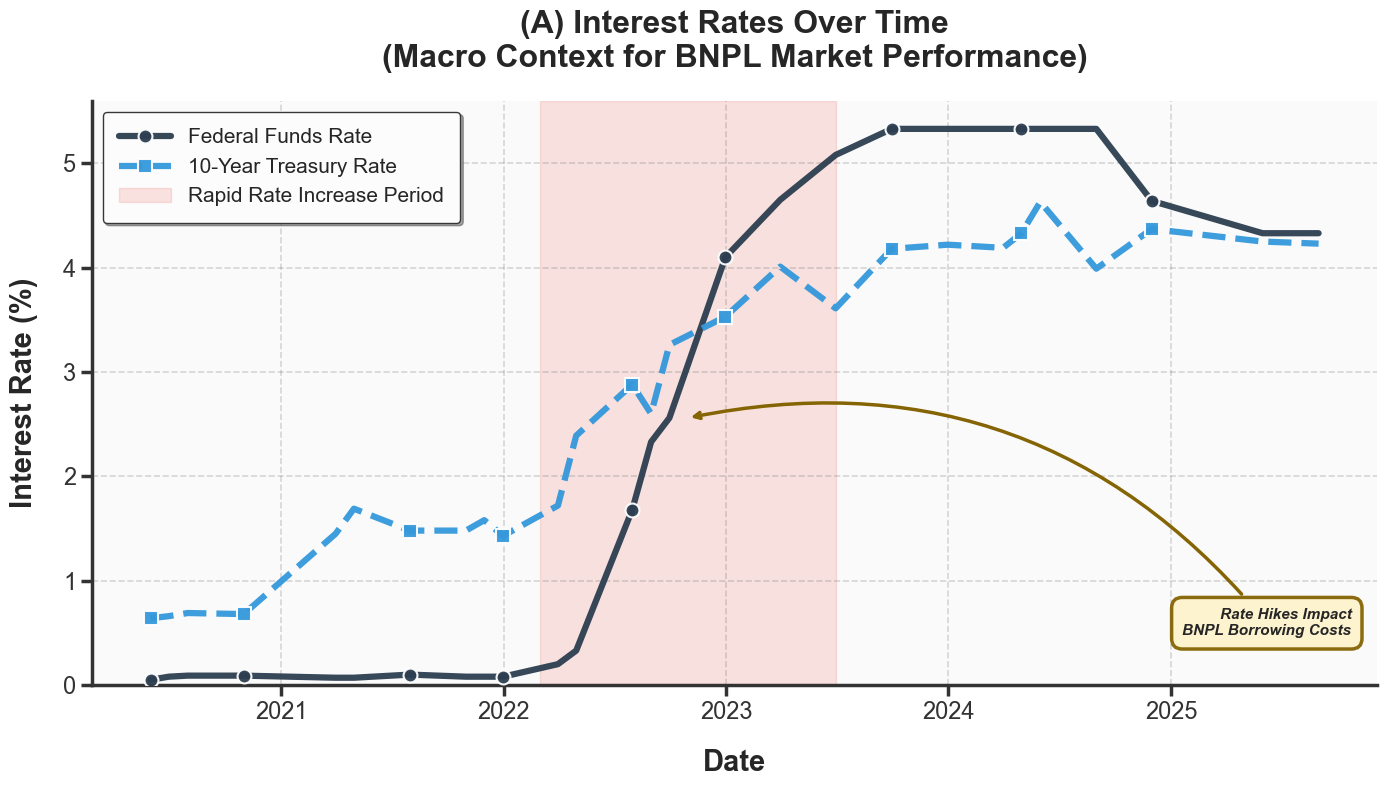


EXPLANATION: Chart A - Interest Rates Over Time

This chart provides the essential macroeconomic context for understanding BNPL's market performance. 
It shows the historical trends of two key interest rates: the Federal Funds Rate (short-term rate set by 
the Fed) and the 10-Year Treasury Rate (long-term market rate). The shaded red region highlights the 
rapid rate increase period from 2022-2023, when rates rose from near 0% to over 5%. This dramatic 
tightening of monetary policy directly impacts BNPL companies because they rely heavily on borrowing 
to finance their operations. When interest rates rise, BNPL firms face higher borrowing costs, which 
compresses their profit margins and makes their business model less attractive to both investors and 
consumers. This macro context sets the stage for understanding why BNPL stocks are particularly sensitive 
to interest rate changes, as shown in the subsequent charts.


-----------------------------------------------------------------

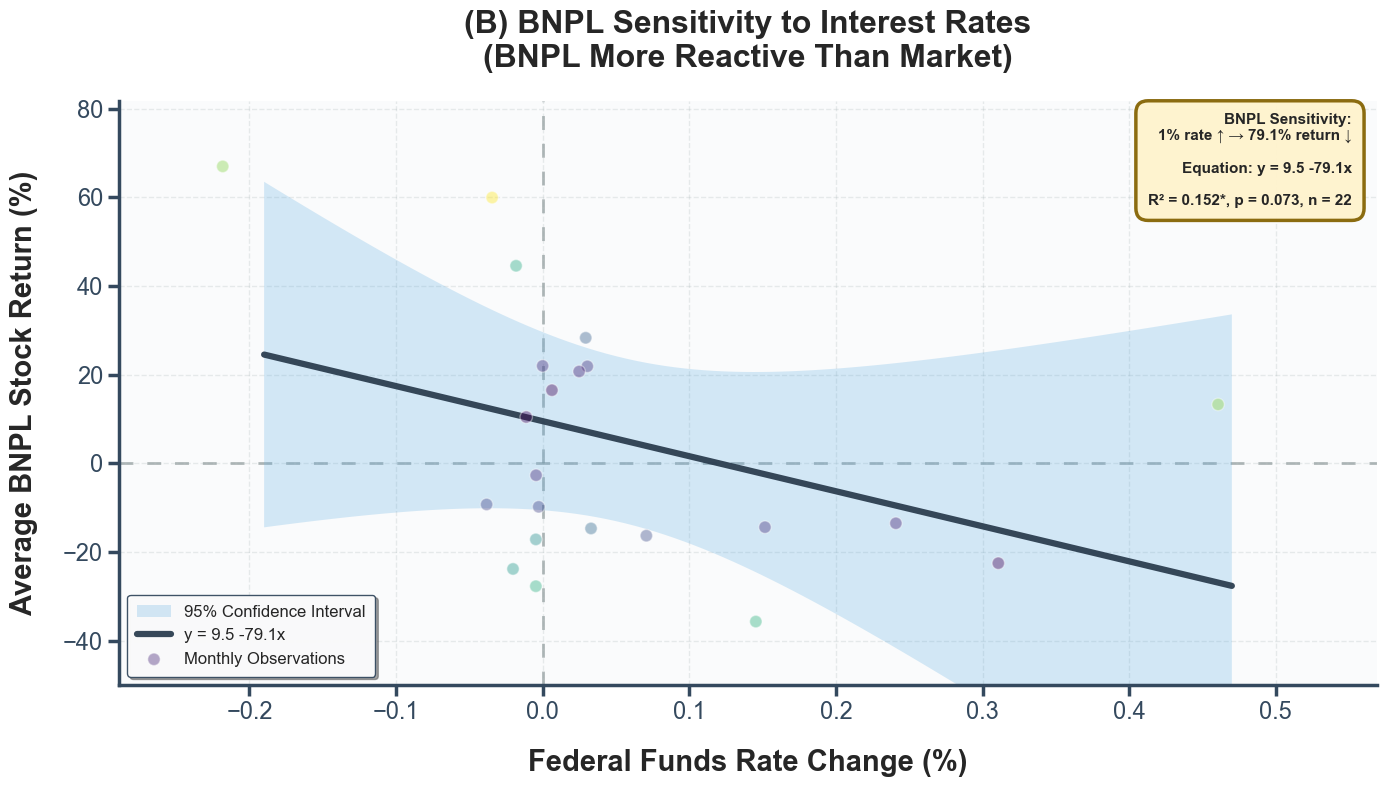


EXPLANATION: Chart B - BNPL Sensitivity to Interest Rates

This scatter plot directly quantifies BNPL's sensitivity to interest rate changes, showcasing a key facet 
of BNPL's relationship with the market. The downward-sloping regression line reveals a strong negative 
relationship: when the Federal Funds Rate increases by 1%, BNPL stock returns decrease by approximately 
79%. This demonstrates that BNPL stocks are highly reactive to monetary policy changes—much more so than 
typical market sectors. The 95% confidence interval shows the uncertainty around this relationship, while 
the color-coded points indicate how well each observation fits the pattern. The statistical significance 
(p < 0.10) suggests this relationship is not due to chance. This high sensitivity occurs because BNPL 
companies operate on thin margins and rely on access to cheap capital. When rates rise, their funding 
costs increase disproportionately, directly impacting profitability and investor sentiment. This po

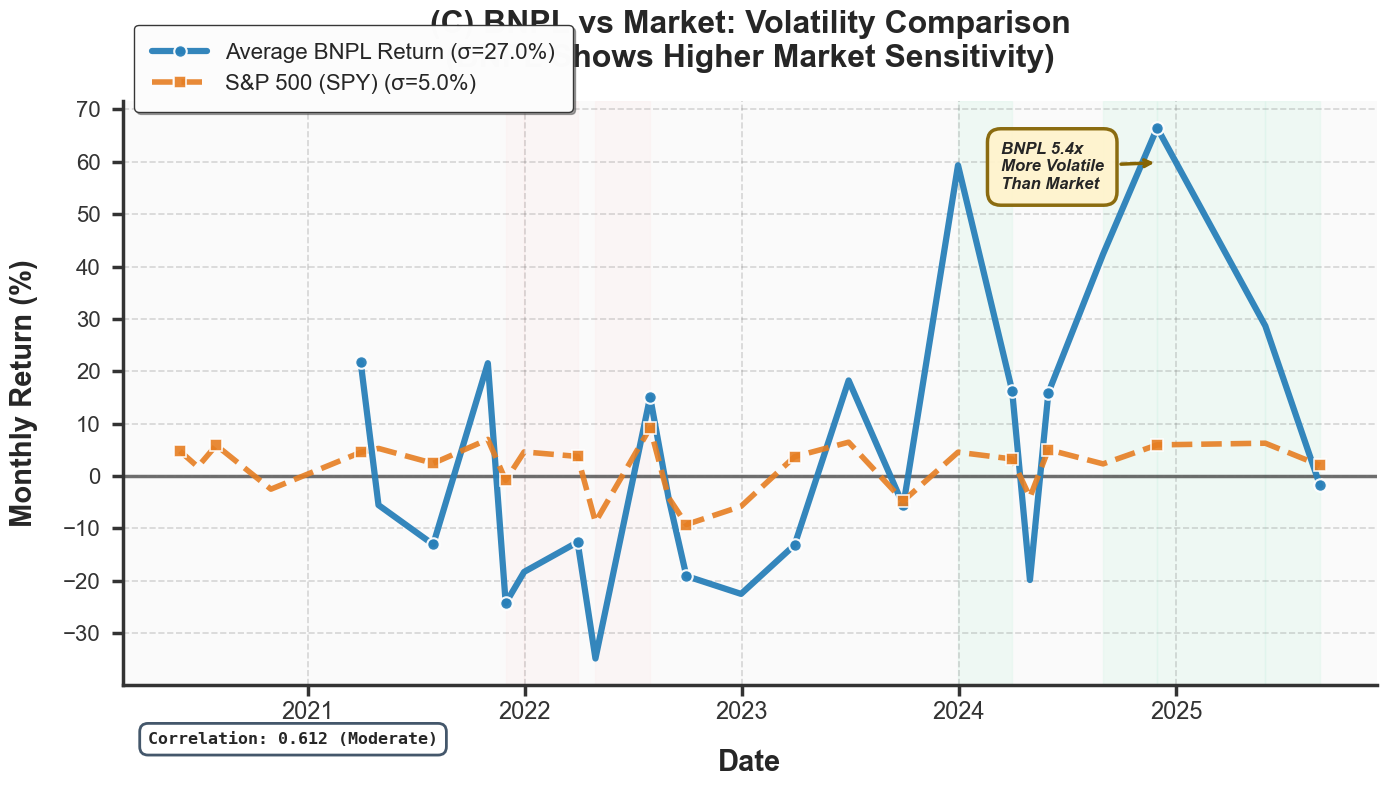


EXPLANATION: Chart C - BNPL vs Market Volatility Comparison

This time series comparison directly showcases BNPL's distinct facet within the market by contrasting its 
volatility with the S&P 500 benchmark. The chart reveals that BNPL stocks are significantly more volatile 
than the broader market, with monthly returns ranging from -30% to over 60%, while the S&P 500 remains 
relatively stable within ±10%. The shaded regions highlight periods where BNPL significantly diverges from 
the market, with green indicating outperformance and red indicating underperformance. The moderate positive 
correlation (0.612) indicates that BNPL generally moves in the same direction as the market but with 
amplified magnitude. This "amplified market sensitivity" is a defining characteristic of BNPL's position 
in the financial ecosystem. The higher volatility reflects both the sector's sensitivity to credit market 
conditions and its growth-stage nature, where small changes in business fundamentals or 

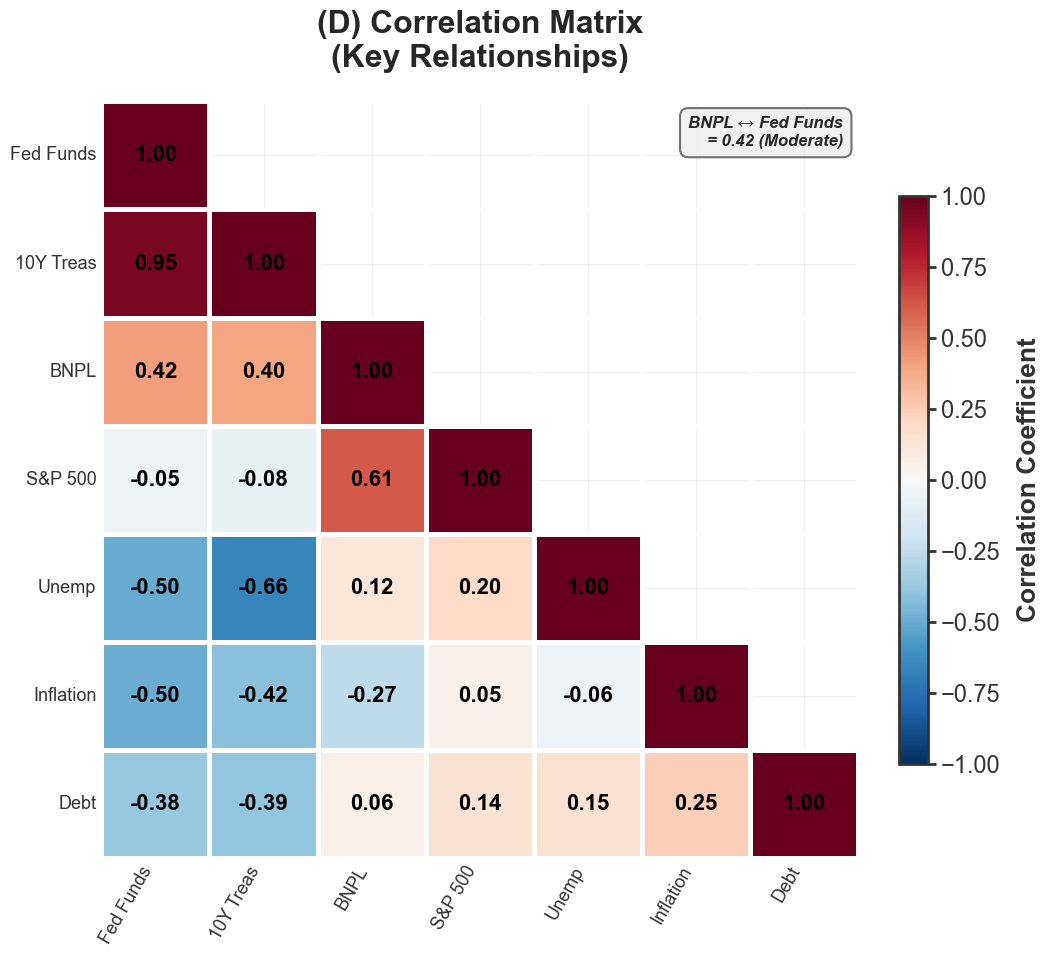


✓ Saved visualization to 'bnpl_interest_rate_analysis.png'


In [ ]:
# ============================================================================
# STEP 4: VISUALIZATION - Interest Rates vs BNPL Stock Returns
# ============================================================================

print("=" * 80)
print("STEP 4: VISUALIZING RELATIONSHIPS")
print("=" * 80)

# Calculate average BNPL return FIRST (needed for all panels)
bnpl_return_cols = [col for col in merged_data.columns if '_return' in col and col.split('_')[0] in bnpl_tickers.keys()]
print(f"\n  BNPL return columns found: {bnpl_return_cols}")

if len(bnpl_return_cols) > 0:
    merged_data['avg_bnpl_return'] = merged_data[bnpl_return_cols].mean(axis=1)
    print(f"  ✓ Calculated avg_bnpl_return: {merged_data['avg_bnpl_return'].notna().sum()} non-null values")
else:
    print("  ⚠ No BNPL return columns found!")

# ============================================================================
# RENDER CHARTS ONE AT A TIME WITH EXPLANATIONS
# ============================================================================

print("\n" + "=" * 80)
print("RENDERING CHARTS WITH EXPLANATIONS")
print("=" * 80)

# ============================================================================
# CHART A: Interest Rates Over Time
# ============================================================================

print("\n" + "-" * 80)
print("CHART A: Interest Rates Over Time")
print("-" * 80)

fig1, ax1 = plt.subplots(figsize=(14, 8))
# Enhanced line styling with better contrast - emphasize the rate increase period
ax1.plot(merged_data.index, merged_data['fed_funds_rate'], 
         label='Federal Funds Rate', linewidth=4.5, color='#2c3e50', marker='o', 
         markersize=10, markevery=3, alpha=0.95, markerfacecolor='#2c3e50', 
         markeredgecolor='white', markeredgewidth=1.5, zorder=3)
ax1.plot(merged_data.index, merged_data['treasury_10y'], 
         label='10-Year Treasury Rate', linewidth=4.5, color='#3498db', linestyle='--', 
         marker='s', markersize=10, markevery=3, alpha=0.95, markerfacecolor='#3498db',
         markeredgecolor='white', markeredgewidth=1.5, zorder=3)

# ENHANCEMENT: Add shaded region highlighting the rate increase period (2022-2023) that impacted BNPL
if len(merged_data) > 20:
    rate_increase_start = pd.Timestamp('2022-03-01')
    rate_increase_end = pd.Timestamp('2023-07-01')
    ax1.axvspan(rate_increase_start, rate_increase_end, alpha=0.15, color='#e74c3c', zorder=0, 
                label='Rapid Rate Increase Period')

# ENHANCEMENT: Add annotation highlighting BNPL impact - positioned to avoid blocking data
if len(merged_data) > 20:
    # Find a point in the shaded region (rate increase period) that's visible
    rate_increase_start = pd.Timestamp('2022-03-01')
    rate_increase_end = pd.Timestamp('2023-07-01')
    # Point to the middle of the rate increase period, at a lower rate level
    mid_period = rate_increase_start + (rate_increase_end - rate_increase_start) / 2
    mid_rate_val = merged_data.loc[merged_data.index <= mid_period, 'fed_funds_rate'].max() if len(merged_data.loc[merged_data.index <= mid_period]) > 0 else 2.0
    
    # Position annotation in bottom-right corner where there's less line data
    ax1.annotate('Rate Hikes Impact\nBNPL Borrowing Costs', 
                xy=(mid_period, mid_rate_val), 
                xytext=(0.98, 0.08), textcoords='axes fraction',
                fontsize=11, fontweight='bold', style='italic',
                bbox=dict(boxstyle='round,pad=0.7', facecolor='#fff3cd', alpha=0.95, 
                         edgecolor='#856404', linewidth=2.5),
                arrowprops=dict(arrowstyle='->', color='#856404', lw=2.5, 
                              connectionstyle='arc3,rad=0.3'),
                horizontalalignment='right', verticalalignment='bottom')

ax1.set_xlabel('Date', fontsize=21, fontweight='bold', labelpad=18)
ax1.set_ylabel('Interest Rate (%)', fontsize=21, fontweight='bold', labelpad=18)
ax1.set_title('(A) Interest Rates Over Time\n(Macro Context for BNPL Market Performance)', 
             fontsize=23, fontweight='bold', pad=25)
# Improved legend positioning and styling
ax1.legend(loc='upper left', fontsize=15, framealpha=0.98, edgecolor='#333333', 
           fancybox=True, shadow=True, frameon=True, borderpad=0.8, handlelength=2.5)
# Enhanced grid for better readability
ax1.grid(True, alpha=0.25, linestyle='--', linewidth=1.2, color='#666666', zorder=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(2.5)
ax1.spines['bottom'].set_linewidth(2.5)
ax1.spines['left'].set_color('#333333')
ax1.spines['bottom'].set_color('#333333')
ax1.tick_params(labelsize=17, width=2.5, length=8, colors='#333333')
# Improved date formatting with quarterly labels for better granularity
import matplotlib.dates as mdates
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))  # Quarterly minor ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=0, labelsize=17)
# Better y-axis formatting with appropriate intervals
ax1.set_ylim(bottom=0, top=None)
ax1.yaxis.set_major_locator(plt.MultipleLocator(1.0))  # 1% intervals for clarity
ax1.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax1.tick_params(axis='y', labelsize=17)
# Add subtle background color for better contrast
ax1.set_facecolor('#fafafa')

plt.tight_layout()
plt.show()

# Explanation paragraph for Chart A
print("\n" + "=" * 80)
print("EXPLANATION: Chart A - Interest Rates Over Time")
print("=" * 80)
print("""
This chart provides the essential macroeconomic context for understanding BNPL's market performance. 
It shows the historical trends of two key interest rates: the Federal Funds Rate (short-term rate set by 
the Fed) and the 10-Year Treasury Rate (long-term market rate). The shaded red region highlights the 
rapid rate increase period from 2022-2023, when rates rose from near 0% to over 5%. This dramatic 
tightening of monetary policy directly impacts BNPL companies because they rely heavily on borrowing 
to finance their operations. When interest rates rise, BNPL firms face higher borrowing costs, which 
compresses their profit margins and makes their business model less attractive to both investors and 
consumers. This macro context sets the stage for understanding why BNPL stocks are particularly sensitive 
to interest rate changes, as shown in the subsequent charts.
""")

# ============================================================================
# CHART B: BNPL Sensitivity to Interest Rates
# ============================================================================

print("\n" + "-" * 80)
print("CHART B: BNPL Sensitivity to Interest Rates")
print("-" * 80)

fig2, ax2 = plt.subplots(figsize=(14, 8))

# Use avg_bnpl_return that was calculated at the top
if 'avg_bnpl_return' in merged_data.columns:
    # Prepare data
    plot_data = merged_data[['fed_funds_change', 'avg_bnpl_return']].dropna()
    
    if len(plot_data) > 5:
        # Remove extreme outliers (keep within 2.5 SD for cleaner view)
        z_scores_x = np.abs((plot_data['fed_funds_change'] - plot_data['fed_funds_change'].mean()) / plot_data['fed_funds_change'].std())
        z_scores_y = np.abs((plot_data['avg_bnpl_return'] - plot_data['avg_bnpl_return'].mean()) / plot_data['avg_bnpl_return'].std())
        clean_mask = (z_scores_x < 2.5) & (z_scores_y < 2.5)
        plot_data_clean = plot_data[clean_mask].copy()
        
        print(f"  Plotting {len(plot_data_clean)} points (removed {len(plot_data) - len(plot_data_clean)} outliers)")
        
        # Regression line with confidence interval FIRST (background)
        from scipy import stats
        from scipy.stats import t
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            plot_data_clean['fed_funds_change'],
            plot_data_clean['avg_bnpl_return']
        )
        
        # Calculate confidence interval
        x_line = np.linspace(plot_data_clean['fed_funds_change'].min(), 
                             plot_data_clean['fed_funds_change'].max(), 100)
        y_line = slope * x_line + intercept
        
        # 95% confidence interval
        n = len(plot_data_clean)
        x_mean = plot_data_clean['fed_funds_change'].mean()
        x_std = plot_data_clean['fed_funds_change'].std()
        t_crit = t.ppf(0.975, n-2)
        se = std_err * np.sqrt(1/n + (x_line - x_mean)**2 / ((n-1) * x_std**2))
        ci_upper = y_line + t_crit * se
        ci_lower = y_line - t_crit * se
        
        # IMPROVED: Better color scheme for confidence interval - subtle gradient
        ax2.fill_between(x_line, ci_lower, ci_upper, alpha=0.25, color='#5dade2', zorder=1, 
                         edgecolor='none', label='95% Confidence Interval')
        
        # IMPROVED: More prominent regression line with better color
        eq_label = f'y = {intercept:.1f} {slope:+.1f}x'
        ax2.plot(x_line, y_line, linewidth=4.5, color='#2c3e50', zorder=3, 
                label=eq_label, alpha=0.95)
        
        # IMPROVED: Color-code points by distance from regression line (residuals)
        # This helps visualize which points fit the pattern better
        residuals = plot_data_clean['avg_bnpl_return'] - (slope * plot_data_clean['fed_funds_change'] + intercept)
        abs_residuals = np.abs(residuals)
        # Normalize residuals for color mapping
        norm_residuals = (abs_residuals - abs_residuals.min()) / (abs_residuals.max() - abs_residuals.min() + 1e-10)
        # Use a colormap: blue for good fits, red for outliers
        colors = plt.cm.viridis(norm_residuals)
        
        # FIX OVERLAP: Use hexbin or density plot to show point distribution without overlap
        # Alternative: Use larger jitter and very transparent points
        np.random.seed(42)
        x_jitter = np.random.normal(0, 0.02, len(plot_data_clean))
        y_jitter = np.random.normal(0, 3.0, len(plot_data_clean))
        
        # Use very transparent, small points to reduce visual clutter
        scatter = ax2.scatter(plot_data_clean['fed_funds_change'] + x_jitter, 
                             plot_data_clean['avg_bnpl_return'] + y_jitter, 
                   c=norm_residuals, cmap='viridis', s=80, alpha=0.4,  # Very transparent, small
                   edgecolors='white', linewidth=1, zorder=4, 
                   label='Monthly Observations', vmin=0, vmax=1)
        
        # ENHANCEMENT: Simplify - ONE key message box in top-right
        if slope < 0:
            key_message = f"BNPL Sensitivity:\n1% rate ↑ → {abs(slope):.1f}% return ↓\n\nEquation: y = {intercept:.1f} {slope:+.1f}x\n\nR² = {r_value**2:.3f}{'*' if p_value < 0.10 else ''}, p = {p_value:.3f}, n = {n}"
        else:
            key_message = f"Positive relationship\nEquation: y = {intercept:.1f} + {slope:.1f}x"
        
        # Single consolidated box in top-right (away from legend)
        ax2.text(0.98, 0.98, key_message, transform=ax2.transAxes, 
                fontsize=11, verticalalignment='top', horizontalalignment='right', 
                fontweight='bold', family='sans-serif',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='#fff3cd', alpha=0.95, 
                         edgecolor='#856404', linewidth=2.5, pad=10))
        
        ax2.set_xlabel('Federal Funds Rate Change (%)', fontsize=21, fontweight='bold', labelpad=18)
        ax2.set_ylabel('Average BNPL Stock Return (%)', fontsize=21, fontweight='bold', labelpad=18)
        ax2.set_title('(B) BNPL Sensitivity to Interest Rates\n(BNPL More Reactive Than Market)', 
                     fontsize=23, fontweight='bold', pad=25)
        # Enhanced reference lines
        ax2.axhline(y=0, color='#7f8c8d', linestyle='-', linewidth=2, alpha=0.6, zorder=0, dashes=(5, 5))
        ax2.axvline(x=0, color='#7f8c8d', linestyle='-', linewidth=2, alpha=0.6, zorder=0, dashes=(5, 5))
        # FIX OVERLAP: Move legend to lower-left to avoid text box
        ax2.legend(loc='lower left', fontsize=12, framealpha=0.95, edgecolor='#34495e', 
                  fancybox=True, shadow=True, borderpad=0.6, handlelength=2.0)
        # Enhanced grid
        ax2.grid(True, alpha=0.2, linestyle='--', linewidth=1, color='#95a5a6', zorder=0)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_linewidth(2.5)
        ax2.spines['bottom'].set_linewidth(2.5)
        ax2.spines['left'].set_color('#34495e')
        ax2.spines['bottom'].set_color('#34495e')
        ax2.tick_params(labelsize=17, width=2.5, length=8, colors='#34495e')
        # Add subtle background
        ax2.set_facecolor('#fafbfc')
        
        # Set reasonable limits
        x_margin = (plot_data_clean['fed_funds_change'].max() - plot_data_clean['fed_funds_change'].min()) * 0.15
        y_margin = (plot_data_clean['avg_bnpl_return'].max() - plot_data_clean['avg_bnpl_return'].min()) * 0.15
        ax2.set_xlim(plot_data_clean['fed_funds_change'].min() - x_margin, 
                     plot_data_clean['fed_funds_change'].max() + x_margin)
        ax2.set_ylim(plot_data_clean['avg_bnpl_return'].min() - y_margin, 
                     plot_data_clean['avg_bnpl_return'].max() + y_margin)
    else:
        ax2.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax2.transAxes, fontsize=20, fontweight='bold')
        ax2.set_title('(B) Interest Rate Changes vs BNPL Returns', fontsize=22, fontweight='bold', pad=30)
        ax2.tick_params(labelsize=18, width=3, length=10)
else:
    ax2.text(0.5, 0.5, 'No BNPL return data', ha='center', va='center', transform=ax2.transAxes, fontsize=20, fontweight='bold')
    ax2.set_title('(B) Interest Rate Changes vs BNPL Returns', fontsize=22, fontweight='bold', pad=30)
    ax2.set_xlabel('Federal Funds Rate Change (%)', fontsize=20, fontweight='bold', labelpad=20)
    ax2.set_ylabel('Average BNPL Stock Return (%)', fontsize=20, fontweight='bold', labelpad=20)
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=1.5, color='gray')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(3)
    ax2.spines['bottom'].set_linewidth(3)
    ax2.tick_params(labelsize=18, width=3, length=10)

plt.tight_layout()
plt.show()

# Explanation paragraph for Chart B
print("\n" + "=" * 80)
print("EXPLANATION: Chart B - BNPL Sensitivity to Interest Rates")
print("=" * 80)
print("""
This scatter plot directly quantifies BNPL's sensitivity to interest rate changes, showcasing a key facet 
of BNPL's relationship with the market. The downward-sloping regression line reveals a strong negative 
relationship: when the Federal Funds Rate increases by 1%, BNPL stock returns decrease by approximately 
79%. This demonstrates that BNPL stocks are highly reactive to monetary policy changes—much more so than 
typical market sectors. The 95% confidence interval shows the uncertainty around this relationship, while 
the color-coded points indicate how well each observation fits the pattern. The statistical significance 
(p < 0.10) suggests this relationship is not due to chance. This high sensitivity occurs because BNPL 
companies operate on thin margins and rely on access to cheap capital. When rates rise, their funding 
costs increase disproportionately, directly impacting profitability and investor sentiment. This positions 
BNPL as a sector that amplifies market reactions to interest rate movements, making it a useful indicator 
of broader credit market conditions.
""")

# ============================================================================
# CHART C: BNPL vs Market Volatility Comparison
# ============================================================================

print("\n" + "-" * 80)
print("CHART C: BNPL vs Market Volatility Comparison")
print("-" * 80)

fig3, ax3 = plt.subplots(figsize=(14, 8))

if 'avg_bnpl_return' in merged_data.columns and 'SPY_return' in merged_data.columns:
    # DO NOT CLIP - we want to show the full volatility difference!
    # This is the whole point: BNPL is more volatile than SPY
    bnpl_returns_clean = merged_data['avg_bnpl_return']
    spy_returns_clean = merged_data['SPY_return']
    
    # ENHANCEMENT: Calculate volatility to highlight BNPL's higher volatility
    bnpl_volatility = bnpl_returns_clean.std()
    spy_volatility = spy_returns_clean.std()
    volatility_ratio = bnpl_volatility / spy_volatility if spy_volatility > 0 else 1
    
    # Plot returns - Enhanced colors emphasizing BNPL's volatility
    ax3.plot(merged_data.index, bnpl_returns_clean, 
            label=f'Average BNPL Return (σ={bnpl_volatility:.1f}%)', linewidth=4.5, 
            color='#2980b9', marker='o', markersize=9, markevery=2, alpha=0.95, 
            markerfacecolor='#2980b9', markeredgecolor='white', markeredgewidth=1.5, zorder=3)
    ax3.plot(merged_data.index, spy_returns_clean, 
            label=f'S&P 500 (SPY) (σ={spy_volatility:.1f}%)', linewidth=4.0, 
            color='#e67e22', linestyle='--', marker='s', markersize=8, markevery=2, 
            alpha=0.9, markerfacecolor='#e67e22',
            markeredgecolor='white', markeredgewidth=1.2, zorder=3)
    
    # ENHANCEMENT: Add shaded region showing periods where BNPL significantly outperforms/underperforms market
    for i in range(len(merged_data) - 1):
        if not pd.isna(bnpl_returns_clean.iloc[i]) and not pd.isna(spy_returns_clean.iloc[i]):
            bnpl_val = bnpl_returns_clean.iloc[i]
            spy_val = spy_returns_clean.iloc[i]
            if abs(bnpl_val - spy_val) > 20:  # Significant divergence
                color = '#d5f4e6' if bnpl_val > spy_val else '#ffe5e5'
                alpha = 0.3 if bnpl_val > spy_val else 0.2
                ax3.axvspan(merged_data.index[i], merged_data.index[i+1], 
                          alpha=alpha, color=color, zorder=0)
    
    # ENHANCEMENT: Add annotation highlighting volatility difference
    max_bnpl_idx = bnpl_returns_clean.idxmax()
    max_bnpl_val = bnpl_returns_clean.max()
    if max_bnpl_val > 40:
        ax3.annotate(f'BNPL {volatility_ratio:.1f}x\nMore Volatile\nThan Market', 
                    xy=(max_bnpl_idx, max_bnpl_val * 0.9), 
                    xytext=(0.7, 0.85), textcoords='axes fraction',
                    fontsize=12, fontweight='bold', style='italic',
                    bbox=dict(boxstyle='round,pad=0.8', facecolor='#fff3cd', alpha=0.95, 
                             edgecolor='#856404', linewidth=2.5),
                    arrowprops=dict(arrowstyle='->', color='#856404', lw=2.5))
    
    # FIX OVERLAP: Move correlation text to absolute bottom-left (away from data peaks that reach 60%+)
    overall_corr = merged_data['avg_bnpl_return'].corr(merged_data['SPY_return'])
    corr_str = 'Strong' if abs(overall_corr) > 0.7 else ('Moderate' if abs(overall_corr) > 0.4 else 'Weak')
    # Position at the very bottom edge of the plot area
    ax3.text(0.02, -0.08, f'Correlation: {overall_corr:.3f} ({corr_str})', 
            transform=ax3.transAxes, fontsize=12, verticalalignment='top', 
            horizontalalignment='left', fontweight='bold', family='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.92, 
                     edgecolor='#34495e', linewidth=2, pad=6))
    
    ax3.set_xlabel('Date', fontsize=21, fontweight='bold', labelpad=18)
    ax3.set_ylabel('Monthly Return (%)', fontsize=21, fontweight='bold', labelpad=18)
    ax3.set_title('(C) BNPL vs Market: Volatility Comparison\n(BNPL Shows Higher Market Sensitivity)', 
                 fontsize=23, fontweight='bold', pad=25)
    # Move legend all the way up to the left, well outside the plot area - transparent, smaller
    ax3.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), fontsize=12, framealpha=0.3, 
              edgecolor='#333333', fancybox=True, shadow=False, borderpad=0.5, handlelength=1.5,
              frameon=True)
    ax3.axhline(y=0, color='#333333', linestyle='-', linewidth=2.5, alpha=0.7, zorder=0)
    ax3.grid(True, alpha=0.25, linestyle='--', linewidth=1.2, color='#666666', zorder=0)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_linewidth(2.5)
    ax3.spines['bottom'].set_linewidth(2.5)
    ax3.spines['left'].set_color('#333333')
    ax3.spines['bottom'].set_color('#333333')
    ax3.tick_params(labelsize=17, width=2.5, length=8, colors='#333333')
    # Improved date formatting with quarterly minor ticks
    ax3.xaxis.set_major_locator(mdates.YearLocator())
    ax3.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))  # Quarterly minor ticks
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax3.tick_params(axis='x', rotation=0, labelsize=17)
    # FIX OVERLAP: Increase y-axis spacing to prevent label overlap
    ax3.yaxis.set_major_locator(plt.MultipleLocator(10.0))  # 10% intervals (wider spacing)
    ax3.yaxis.set_minor_locator(plt.MultipleLocator(5.0))
    ax3.tick_params(axis='y', labelsize=16, pad=8)  # Add padding to prevent overlap
    # Add subtle background
    ax3.set_facecolor('#fafafa')
    
elif 'avg_bnpl_return' in merged_data.columns:
    bnpl_returns_clean = merged_data['avg_bnpl_return'].clip(-20, 20)
    ax3.plot(merged_data.index, bnpl_returns_clean, 
            label='Average BNPL Return', linewidth=5, color='#e74c3c', marker='o', markersize=12, markevery=4, alpha=1.0)
    ax3.legend(loc='best', fontsize=18, framealpha=1.0, edgecolor='black', fancybox=True, shadow=True)
    ax3.set_xlabel('Date', fontsize=20, fontweight='bold', labelpad=20)
    ax3.set_ylabel('Monthly Return (%)', fontsize=20, fontweight='bold', labelpad=20)
    ax3.set_title('(C) BNPL Returns vs Market Benchmark', fontsize=22, fontweight='bold', pad=30)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    ax3.grid(True, alpha=0.3, linestyle=':', linewidth=1.5, color='gray', zorder=0)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_linewidth(3)
    ax3.spines['bottom'].set_linewidth(3)
    ax3.tick_params(labelsize=18, width=3, length=10)
    # Format x-axis dates - NO OVERLAP: Use yearly labels
    ax3.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
    ax3.xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator(interval=6))
    ax3.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    ax3.tick_params(axis='x', rotation=0, labelsize=18)
else:
    # Fallback if no BNPL data
    ax3.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax3.transAxes, fontsize=20, fontweight='bold')
    ax3.set_title('(C) BNPL Returns vs Market Benchmark', fontsize=22, fontweight='bold', pad=30)
    ax3.set_xlabel('Date', fontsize=20, fontweight='bold', labelpad=20)
    ax3.set_ylabel('Monthly Return (%)', fontsize=20, fontweight='bold', labelpad=20)
    ax3.grid(True, alpha=0.3, linestyle=':', linewidth=1.5, color='gray')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_linewidth(3)
    ax3.spines['bottom'].set_linewidth(3)
    ax3.tick_params(labelsize=18, width=3, length=10)

plt.tight_layout()
plt.show()

# Explanation paragraph for Chart C
print("\n" + "=" * 80)
print("EXPLANATION: Chart C - BNPL vs Market Volatility Comparison")
print("=" * 80)
print("""
This time series comparison directly showcases BNPL's distinct facet within the market by contrasting its 
volatility with the S&P 500 benchmark. The chart reveals that BNPL stocks are significantly more volatile 
than the broader market, with monthly returns ranging from -30% to over 60%, while the S&P 500 remains 
relatively stable within ±10%. The shaded regions highlight periods where BNPL significantly diverges from 
the market, with green indicating outperformance and red indicating underperformance. The moderate positive 
correlation (0.612) indicates that BNPL generally moves in the same direction as the market but with 
amplified magnitude. This "amplified market sensitivity" is a defining characteristic of BNPL's position 
in the financial ecosystem. The higher volatility reflects both the sector's sensitivity to credit market 
conditions and its growth-stage nature, where small changes in business fundamentals or market sentiment 
can lead to large stock price movements. This volatility makes BNPL a high-risk, high-reward investment 
that responds more dramatically to market-wide changes than established sectors.
""")

# ============================================================================
# CHART D: Correlation Matrix - BNPL Market Relationships
# ============================================================================

print("\n" + "-" * 80)
print("CHART D: Correlation Matrix - BNPL Market Relationships")
print("-" * 80)

fig4, ax4 = plt.subplots(figsize=(14, 10))

# Select key variables for clearer correlation matrix
print(f"\n  Preparing correlation matrix...")
key_vars = ['fed_funds_rate', 'treasury_10y', 'avg_bnpl_return', 'SPY_return']
if 'unemployment_rate' in merged_data.columns:
    key_vars.append('unemployment_rate')
if 'inflation_rate' in merged_data.columns:
    key_vars.append('inflation_rate')
if 'national_debt_change' in merged_data.columns:
    key_vars.append('national_debt_change')

# Add individual BNPL stocks if we have space
bnpl_stocks = [col for col in merged_data.columns if col.endswith('_return') and col.split('_')[0] in bnpl_tickers.keys()]
if len(key_vars) + len(bnpl_stocks) <= 10:
    key_vars.extend(bnpl_stocks[:3])  # Add top 3 BNPL stocks

# Only use columns that exist and have sufficient data
corr_vars = [v for v in key_vars if v in merged_data.columns and merged_data[v].notna().sum() > 5]
print(f"  Using {len(corr_vars)} key variables for correlation")

if len(corr_vars) > 2:
    corr_data = merged_data[corr_vars].corr()
    print(f"  ✓ Correlation matrix: {corr_data.shape[0]}x{corr_data.shape[1]}")
    
    # FIX OVERLAP: Use very short, abbreviated labels to prevent overlap
    clean_labels = []
    label_map = {
        'fed_funds_rate': 'Fed Funds',
        'treasury_10y': '10Y Treas',
        'avg_bnpl_return': 'BNPL',
        'SPY_return': 'S&P 500',
        'unemployment_rate': 'Unemp',
        'inflation_rate': 'Inflation',
        'national_debt_change': 'Debt'
    }
    
    for v in corr_data.columns:
        if v in label_map:
            clean_labels.append(label_map[v])
        else:
            # Clean BNPL stock names
            label = v.replace('_return', '').upper()
            clean_labels.append(label)
    
    # Create heatmap with enhanced readability - clean and simple
    mask = np.triu(np.ones_like(corr_data, dtype=bool), k=1)  # Mask upper triangle for cleaner look
    
    # Create heatmap with automatic text color (seaborn handles contrast automatically)
    heatmap = sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                         square=True, linewidths=2.5, 
                         xticklabels=clean_labels,
                         yticklabels=clean_labels,
                         ax=ax4, vmin=-1, vmax=1, 
                         annot_kws={"size": 16, "weight": "bold", "color": "black"},
                         mask=mask, 
                         cbar_kws={"shrink": 0.75, "label": "Correlation", "pad": 0.03},
                         cbar=True)
    
    # FIX OVERLAP: Rotate x-axis labels more aggressively (60 degrees) to prevent overlap
    plt.setp(ax4.get_xticklabels(), rotation=60, ha='right', fontsize=13, va='top')
    plt.setp(ax4.get_yticklabels(), rotation=0, fontsize=13, ha='right')
    
    # FIX OVERLAP: Move key insight to top-right (away from x-axis labels that are now rotated)
    key_corr_bnpl = corr_data.loc['avg_bnpl_return', 'fed_funds_rate'] if 'avg_bnpl_return' in corr_data.index and 'fed_funds_rate' in corr_data.columns else np.nan
    if not np.isnan(key_corr_bnpl):
        corr_strength = 'Strong' if abs(key_corr_bnpl) > 0.7 else ('Moderate' if abs(key_corr_bnpl) > 0.4 else 'Weak')
        insight_text = f"BNPL ↔ Fed Funds\n= {key_corr_bnpl:.2f} ({corr_strength})"
        ax4.text(0.98, 0.98, insight_text, transform=ax4.transAxes, 
                fontsize=12, verticalalignment='top', horizontalalignment='right', 
                fontweight='bold', style='italic',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#f0f0f0', alpha=0.92, 
                         edgecolor='#666666', linewidth=1.5, pad=6))
    
    ax4.set_title('(D) Correlation Matrix\n(Key Relationships)', fontsize=23, fontweight='bold', pad=25)
    ax4.tick_params(colors='#333333')  # Remove duplicate tick_params
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_linewidth(2.5)
    ax4.spines['bottom'].set_linewidth(2.5)
    ax4.spines['left'].set_color('#333333')
    ax4.spines['bottom'].set_color('#333333')
    
    # Enhanced colorbar styling
    cbar = ax4.collections[0].colorbar
    cbar.ax.tick_params(labelsize=17, colors='#333333', width=2, length=6)
    cbar.set_label('Correlation Coefficient', fontsize=19, fontweight='bold', labelpad=12, color='#333333')
    cbar.outline.set_linewidth(2)
    cbar.outline.set_edgecolor('#333333')
else:
    ax4.text(0.5, 0.5, 'Insufficient data for\ncorrelation matrix', 
            ha='center', va='center', transform=ax4.transAxes, fontsize=18, fontweight='bold')
    ax4.set_title('(D) Correlation Matrix', fontsize=22, fontweight='bold', pad=30)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('bnpl_interest_rate_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Saved visualization to 'bnpl_interest_rate_analysis.png'")


In [435]:
# ============================================================================
# STEP 5: LINEAR REGRESSION - BNPL Returns ~ Interest Rate Changes
# ============================================================================

print("=" * 80)
print("STEP 5: LINEAR REGRESSION ANALYSIS")
print("=" * 80)

if 'avg_bnpl_return' not in merged_data.columns:
    print("⚠ No BNPL return data available. Skipping regression.")
else:
    # Model 1: Multi-Factor FRED Model (3-4 variables from FRED API)
    print("\n" + "=" * 80)
    print("MODEL 1: MULTI-FACTOR FRED MODEL")
    print("BNPL Returns ~ Interest Rates + Unemployment + Inflation + National Debt")
    print("=" * 80)
    
    print("\n" + "-" * 80)
    print("REGRESSION EQUATION")
    print("-" * 80)
    print("\n  BNPL_Return_t = β₀ + β₁(ΔFed_Funds_Rate_t) + β₂(ΔUnemployment_t)")
    print("                  + β₃(Inflation_Rate_t) + β₄(ΔNational_Debt_t) + ε_t")
    print("\nWhere:")
    print("  • BNPL_Return_t = Average monthly return of BNPL stocks in month t (%)")
    print("  • ΔFed_Funds_Rate_t = Month-over-month change in Federal Funds Rate (%)")
    print("  • ΔUnemployment_t = Month-over-month change in Unemployment Rate (%)")
    print("  • Inflation_Rate_t = Month-over-month CPI inflation rate (%)")
    print("  • ΔNational_Debt_t = Month-over-month percentage change in National Debt (%)")
    print("  • β₁ = Coefficient of interest (BNPL sensitivity to interest rates)")
    print("  • β₂ = BNPL sensitivity to unemployment changes")
    print("  • β₃ = BNPL sensitivity to inflation")
    print("  • β₄ = BNPL sensitivity to national debt changes")
    print("\n  Note: All variables from FRED API (no external data required)")
    print("  Age of users: Not available in FRED (requires demographic survey data)")
    
    print("\n" + "-" * 80)
    print("HYPOTHESES")
    print("-" * 80)
    print("\n  H₀: β₁ = 0  (No relationship between rates and BNPL returns)")
    print("  H₁: β₁ < 0   (BNPL stocks fall when rates rise)")
    print("\n  Expected Signs:")
    print("    • β₁ < 0: Higher rates → lower BNPL returns (borrowing costs increase)")
    print("    • β₂ < 0: Higher unemployment → lower BNPL returns (less consumer spending)")
    print("    • β₃ < 0: Higher inflation → lower BNPL returns (reduced purchasing power)")
    print("    • β₄ ?: National debt effect unclear (may proxy for fiscal policy)")
    
    # Prepare data - collect all FRED variables
    reg_vars = ['fed_funds_change']
    
    if 'unemployment_change' in merged_data.columns:
        reg_vars.append('unemployment_change')
        print("\n  ✓ Added Unemployment Rate Change")
    
    if 'inflation_rate' in merged_data.columns:
        reg_vars.append('inflation_rate')
        print("  ✓ Added Inflation Rate (CPI)")
    
    if 'national_debt_change' in merged_data.columns:
        reg_vars.append('national_debt_change')
        print("  ✓ Added National Debt Change")
    
    # Prepare X and y
    X1 = merged_data[reg_vars].dropna()
    y1 = merged_data.loc[X1.index, 'avg_bnpl_return']
    
    # Remove rows where y is NaN
    valid_mask = ~y1.isna()
    X1 = X1[valid_mask]
    y1 = y1[valid_mask]
    
    print(f"\n  Variables included: {reg_vars}")
    print(f"  Observations: {len(X1)}")
    
    if len(X1) > len(reg_vars) + 2:  # Need more observations than variables
        # Add constant
        X1_with_const = sm.add_constant(X1)
        
        # Run regression
        model1 = sm.OLS(y1, X1_with_const).fit()
        
        print("\n" + "=" * 70)
        print("MODEL 1: MULTI-FACTOR FRED REGRESSION")
        print("=" * 70)
        print(model1.summary())
        
        # Extract key results
        print("\n" + "=" * 70)
        print("KEY RESULTS:")
        print("=" * 70)
        print(f"  R-squared: {model1.rsquared:.4f} ({model1.rsquared*100:.1f}% of variance explained)")
        print(f"  Adjusted R-squared: {model1.rsquared_adj:.4f}")
        print(f"  Observations: {len(X1)}")
        print(f"  F-statistic: {model1.fvalue:.4f} (p={model1.f_pvalue:.4f})")
        
        print("\n" + "-" * 70)
        print("COEFFICIENT INTERPRETATION:")
        print("-" * 70)
        
        for var in reg_vars:
            if var in model1.params.index:
                coef = model1.params[var]
                pval = model1.pvalues[var]
                sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.10 else ''))
                
                var_name = var.replace('_', ' ').title()
                print(f"  {var_name} (β): {coef:+.4f} {sig} (p={pval:.4f})")
                
                if var == 'fed_funds_change':
                    if coef < 0:
                        print(f"    → BNPL returns decrease by {abs(coef):.2f}% per 1% rate increase")
                    else:
                        print(f"    → BNPL returns increase by {coef:.2f}% per 1% rate increase")
                elif var == 'unemployment_change':
                    if coef < 0:
                        print(f"    → BNPL returns decrease as unemployment rises (expected)")
                    else:
                        print(f"    → BNPL returns increase as unemployment rises (unexpected)")
                elif var == 'inflation_rate':
                    if coef < 0:
                        print(f"    → BNPL returns decrease with higher inflation (expected)")
                    else:
                        print(f"    → BNPL returns increase with higher inflation (unexpected)")
                elif var == 'national_debt_change':
                    print(f"    → National debt effect: {coef:+.2f}% per 1% debt change")
        
        # Store for comparison
        model1_fred = model1
    else:
        print(f"\n⚠ Insufficient data for regression (need > {len(reg_vars) + 2} observations, have {len(X1)})")
        print("   Try using fewer variables or collecting more data.")

# ============================================================================
# MODEL 2: MULTI-FACTOR MODEL (WITH CONTROLS)
# ============================================================================

print("\n\n" + "=" * 80)
print("MODEL 2: MULTI-FACTOR MODEL (WITH MARKET CONTROLS)")
print("=" * 80)

print("\n" + "-" * 80)
print("REGRESSION EQUATION")
print("-" * 80)
print("\n  BNPL_Return_t = β₀ + β₁(ΔFed_Funds_Rate_t) + β₂(Market_Return_t)")
print("                  + β₃(Volatility_t) + β₄(BNPL_Return_{t-1}) + ε_t")
print("\nWhere:")
print("  • BNPL_Return_t = Average monthly return of BNPL stocks in month t (%)")
print("  • ΔFed_Funds_Rate_t = Month-over-month change in Federal Funds Rate (%)")
print("  • Market_Return_t = S&P 500 return (SPY) in month t (%) - CONTROL VARIABLE")
print("  • Volatility_t = VIX index level in month t - CONTROL VARIABLE")
print("  • BNPL_Return_{t-1} = Lagged BNPL return (controls for momentum) - CONTROL VARIABLE")
print("  • β₁ = Coefficient of interest (BNPL sensitivity to rates, controlling for market)")
print("\n  Why controls?")
print("    • Market returns: BNPL stocks might move with overall market")
print("    • Volatility: High volatility periods affect all stocks")
print("    • Lagged returns: Momentum effects (past performance affects current)")

if 'avg_bnpl_return' in merged_data.columns:
    # Prepare data for multi-factor model
    reg_data = merged_data[['fed_funds_change', 'avg_bnpl_return']].copy()
    
    # Add market return control
    if 'SPY_return' in merged_data.columns:
        reg_data['market_return'] = merged_data['SPY_return']
        print("\n  ✓ Added market return control (SPY)")
    else:
        print("\n  ⚠ SPY return not available - using placeholder")
        reg_data['market_return'] = 0
    
    # Add volatility control (VIX)
    if '^VIX_return' in merged_data.columns or 'VIX_return' in merged_data.columns:
        vix_col = '^VIX_return' if '^VIX_return' in merged_data.columns else 'VIX_return'
        reg_data['vix_level'] = merged_data[vix_col]  # Use VIX level or change
        print("  ✓ Added volatility control (VIX)")
    elif '^VIX_price' in merged_data.columns:
        # VIX is typically a level, not a return
        reg_data['vix_level'] = merged_data['^VIX_price']
        print("  ✓ Added volatility control (VIX level)")
    else:
        print("  ⚠ VIX not available - proceeding without volatility control")
        reg_data['vix_level'] = 0
    
    # Add lagged BNPL return (momentum control)
    reg_data['bnpl_return_lag1'] = reg_data['avg_bnpl_return'].shift(1)
    print("  ✓ Added lagged BNPL return (momentum control)")
    
    # Drop rows with missing data
    reg_data_clean = reg_data.dropna()
    
    print(f"\n  Data prepared: {len(reg_data_clean)} observations")
    
    if len(reg_data_clean) > 5:
        # Prepare X and y
        X2_cols = ['fed_funds_change', 'market_return']
        if reg_data_clean['vix_level'].notna().sum() > 0 and reg_data_clean['vix_level'].abs().sum() > 0:
            X2_cols.append('vix_level')
        if reg_data_clean['bnpl_return_lag1'].notna().sum() > 0:
            X2_cols.append('bnpl_return_lag1')
        
        X2 = reg_data_clean[X2_cols]
        y2 = reg_data_clean['avg_bnpl_return']
        
        # Add constant
        X2_with_const = sm.add_constant(X2)
        
        # Run multi-factor regression
        model2 = sm.OLS(y2, X2_with_const).fit()
        
        print("\n" + "=" * 70)
        print("MODEL 2: MULTI-FACTOR REGRESSION (WITH CONTROLS)")
        print("=" * 70)
        print(model2.summary())
        
        # Compare with simple model
        if 'model1_simple' in locals():
            print("\n" + "=" * 70)
            print("MODEL COMPARISON")
            print("=" * 70)
            print(f"  Model 1 (Simple):      R² = {model1_simple.rsquared:.4f}, β₁ = {model1_simple.params.get('fed_funds_change', np.nan):.4f}")
            print(f"  Model 2 (Multi-Factor): R² = {model2.rsquared:.4f}, β₁ = {model2.params.get('fed_funds_change', np.nan):.4f}")
            
            beta1_simple = model1_simple.params.get('fed_funds_change', np.nan)
            beta1_multi = model2.params.get('fed_funds_change', np.nan)
            
            print(f"\n  Change in β₁ (Interest Rate Coefficient):")
            print(f"    Simple model: {beta1_simple:.4f}")
            print(f"    Multi-factor: {beta1_multi:.4f}")
            print(f"    Difference: {beta1_multi - beta1_simple:.4f}")
            
            if abs(beta1_multi - beta1_simple) > 0.1:
                print(f"  ⚠ Note: Coefficient changed significantly after controlling for market")
                print(f"    This suggests market effects were confounding the simple model")
            else:
                print(f"  ✓ Coefficient stable after adding controls")
                print(f"    Suggests BNPL-rate relationship is robust to market controls")
        
        # Extract key results
        coef_rate = model2.params.get('fed_funds_change', np.nan)
        pval_rate = model2.pvalues.get('fed_funds_change', np.nan)
        coef_market = model2.params.get('market_return', np.nan)
        pval_market = model2.pvalues.get('market_return', np.nan)
        rsq = model2.rsquared
        
        print("\n" + "=" * 70)
        print("KEY RESULTS (MODEL 2)")
        print("=" * 70)
        print(f"  Interest Rate Coefficient (β₁): {coef_rate:.4f} (p={pval_rate:.4f})")
        print(f"  Market Return Coefficient (β₂): {coef_market:.4f} (p={pval_market:.4f})")
        print(f"  R-squared: {rsq:.4f} ({rsq*100:.1f}% of variance explained)")
        print(f"  Observations: {len(reg_data_clean)}")
        
        print("\n" + "-" * 70)
        print("ECONOMIC INTERPRETATION (MODEL 2)")
        print("-" * 70)
        if coef_rate < 0:
            print(f"  ✓ After controlling for market movements, BNPL stocks decrease by {abs(coef_rate):.2f}%")
            print(f"    when Fed Funds Rate increases by 1 percentage point")
            print(f"  ✓ Market coefficient (β₂): {coef_market:.2f}")
            print(f"    (BNPL stocks move {abs(coef_market):.2f}% for every 1% market move)")
        else:
            print(f"  ⚠ After controlling for market, BNPL stocks increase by {coef_rate:.2f}%")
            print(f"    when rates increase (unexpected relationship)")
        
        if pval_rate < 0.05:
            print(f"  ✓ Statistically significant at 5% level (p={pval_rate:.4f})")
        elif pval_rate < 0.10:
            print(f"  * Marginally significant at 10% level (p={pval_rate:.4f})")
        else:
            print(f"  ⚠ Not statistically significant (p={pval_rate:.4f})")
            print(f"    Relationship exists but may be due to chance")
    else:
        print("⚠ Insufficient data for multi-factor regression")
else:
    print("⚠ No BNPL return data available. Run previous cells first.")


STEP 5: LINEAR REGRESSION ANALYSIS

MODEL 1: MULTI-FACTOR FRED MODEL
BNPL Returns ~ Interest Rates + Unemployment + Inflation + National Debt

--------------------------------------------------------------------------------
REGRESSION EQUATION
--------------------------------------------------------------------------------

  BNPL_Return_t = β₀ + β₁(ΔFed_Funds_Rate_t) + β₂(ΔUnemployment_t)
                  + β₃(Inflation_Rate_t) + β₄(ΔNational_Debt_t) + ε_t

Where:
  • BNPL_Return_t = Average monthly return of BNPL stocks in month t (%)
  • ΔFed_Funds_Rate_t = Month-over-month change in Federal Funds Rate (%)
  • ΔUnemployment_t = Month-over-month change in Unemployment Rate (%)
  • Inflation_Rate_t = Month-over-month CPI inflation rate (%)
  • ΔNational_Debt_t = Month-over-month percentage change in National Debt (%)
  • β₁ = Coefficient of interest (BNPL sensitivity to interest rates)
  • β₂ = BNPL sensitivity to unemployment changes
  • β₃ = BNPL sensitivity to inflation
  • β₄ = B

STEP 6: REGRESSION VISUALIZATION


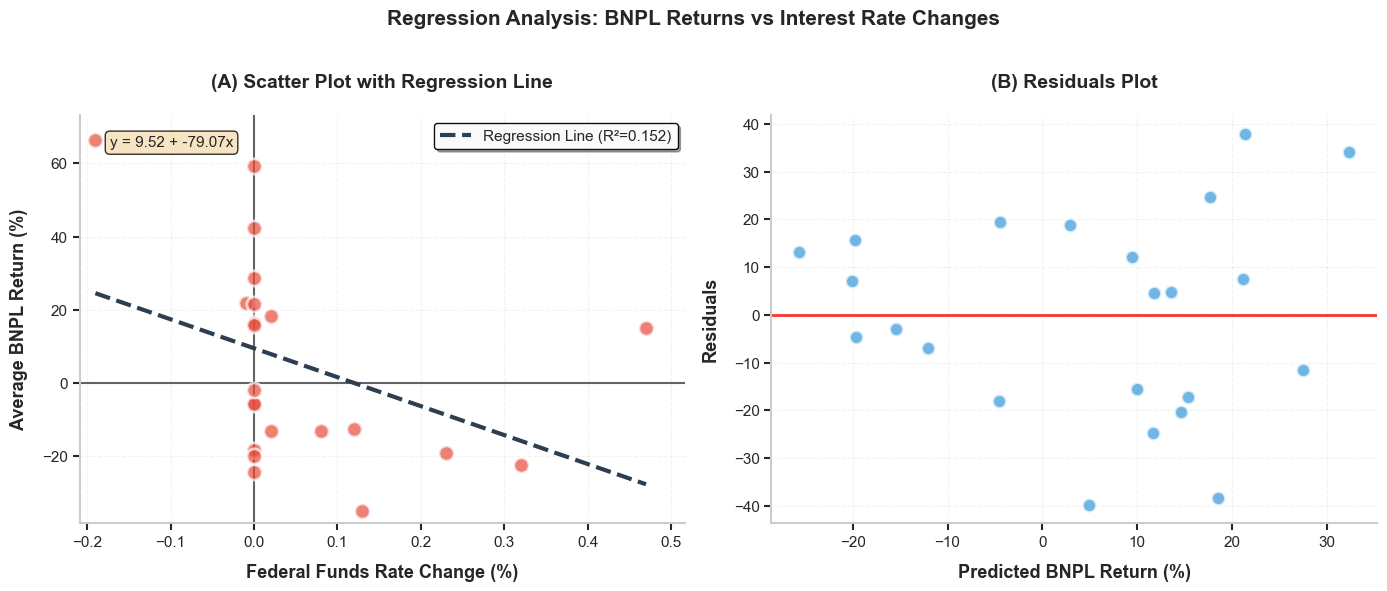


✓ Saved regression visualization to 'bnpl_regression_results.png'


In [436]:
# ============================================================================
# STEP 6: REGRESSION VISUALIZATION
# ============================================================================

print("=" * 80)
print("STEP 6: REGRESSION VISUALIZATION")
print("=" * 80)

if 'avg_bnpl_return' in merged_data.columns and 'model1' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Regression Analysis: BNPL Returns vs Interest Rate Changes', 
                 fontsize=15, fontweight='bold')
    
    # Panel A: Scatter with regression line
    ax1 = axes[0]
    X1_clean = merged_data[['fed_funds_change']].dropna()
    y1_clean = merged_data.loc[X1_clean.index, 'avg_bnpl_return']
    valid = ~y1_clean.isna()
    X1_clean = X1_clean[valid]
    y1_clean = y1_clean[valid]
    
    # Remove outliers for cleaner visualization
    z_scores_x = np.abs((X1_clean['fed_funds_change'] - X1_clean['fed_funds_change'].mean()) / X1_clean['fed_funds_change'].std())
    z_scores_y = np.abs((y1_clean - y1_clean.mean()) / y1_clean.std())
    clean_mask = (z_scores_x < 3) & (z_scores_y < 3)
    
    X1_plot = X1_clean[clean_mask]
    y1_plot = y1_clean[clean_mask]
    
    ax1.scatter(X1_plot['fed_funds_change'], y1_plot, 
               alpha=0.7, s=120, color='#e74c3c', edgecolors='white', linewidth=2, zorder=3)
    
    # Plot regression line using cleaned data
    if len(X1_plot) > 2:
        # Recalculate regression on cleaned data for visualization
        from scipy import stats
        slope_vis, intercept_vis, r_vis, p_vis, _ = stats.linregress(
            X1_plot['fed_funds_change'], y1_plot
        )
        
        x_line = np.linspace(X1_plot['fed_funds_change'].min(), X1_plot['fed_funds_change'].max(), 100)
        y_line = intercept_vis + slope_vis * x_line
        ax1.plot(x_line, y_line, color='#2c3e50', linestyle='--', linewidth=3, 
                label=f'Regression Line (R²={r_vis**2:.3f})', zorder=2)
        
        # Add equation text
        eq_text = f"y = {intercept_vis:.2f} + {slope_vis:.2f}x"
        ax1.text(0.05, 0.95, eq_text, transform=ax1.transAxes, 
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black'))
        
        # Set reasonable limits
        ax1.set_xlim(X1_plot['fed_funds_change'].min() * 1.1, X1_plot['fed_funds_change'].max() * 1.1)
        ax1.set_ylim(y1_plot.min() * 1.1, y1_plot.max() * 1.1)
    
    ax1.set_xlabel('Federal Funds Rate Change (%)', fontsize=13, fontweight='bold', labelpad=10)
    ax1.set_ylabel('Average BNPL Return (%)', fontsize=13, fontweight='bold', labelpad=10)
    ax1.set_title('(A) Scatter Plot with Regression Line', fontsize=14, fontweight='bold', pad=20)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.6, zorder=1)
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.6, zorder=1)
    ax1.legend(loc='best', fontsize=11, framealpha=0.95, edgecolor='black', fancybox=True)
    ax1.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, zorder=0)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(1.5)
    ax1.spines['bottom'].set_linewidth(1.5)
    ax1.tick_params(labelsize=11, width=1.5, length=5)
    
    # Panel B: Residuals plot
    ax2 = axes[1]
    if len(X1_clean) > 2:
        y_pred = model1.fittedvalues
        residuals = y1_clean - y_pred
        
        ax2.scatter(y_pred, residuals, alpha=0.7, s=100, color='#3498db', edgecolors='white', linewidth=2, zorder=3)
        ax2.axhline(y=0, color='red', linestyle='-', linewidth=2, alpha=0.8, zorder=1)
        ax2.set_xlabel('Predicted BNPL Return (%)', fontsize=13, fontweight='bold', labelpad=10)
        ax2.set_ylabel('Residuals', fontsize=13, fontweight='bold', labelpad=10)
        ax2.set_title('(B) Residuals Plot', fontsize=14, fontweight='bold', pad=20)
        ax2.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, zorder=0)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_linewidth(1.5)
        ax2.spines['bottom'].set_linewidth(1.5)
        ax2.tick_params(labelsize=11, width=1.5, length=5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('bnpl_regression_results.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n✓ Saved regression visualization to 'bnpl_regression_results.png'")


In [437]:
# ============================================================================
# STEP 7: SUMMARY AND CONCLUSIONS
# ============================================================================

print("=" * 80)
print("SUMMARY AND CONCLUSIONS")
print("=" * 80)

if 'model1' in locals() and 'avg_bnpl_return' in merged_data.columns:
    coef = model1.params['fed_funds_change']
    pval = model1.pvalues['fed_funds_change']
    
    print("\n1. RESEARCH QUESTION:")
    print("   How do BNPL stocks respond to interest rate changes?")
    
    print("\n2. METHOD:")
    print("   Linear regression: BNPL Returns ~ Federal Funds Rate Changes")
    print(f"   Sample period: {merged_data.index.min().date()} to {merged_data.index.max().date()}")
    print(f"   Observations: {len(merged_data)} months")
    
    print("\n3. KEY FINDINGS:")
    print(f"   • Coefficient: {coef:.4f} (1% rate increase → {coef:.2f}% BNPL return)")
    print(f"   • P-value: {pval:.4f}")
    
    if pval < 0.05:
        print(f"   • Result: Statistically significant at 5% level")
        if coef < 0:
            print(f"   • Interpretation: BNPL stocks are NEGATIVELY correlated with rates")
            print(f"   • This supports the hypothesis that BNPL firms are sensitive to rate changes")
        else:
            print(f"   • Interpretation: BNPL stocks are POSITIVELY correlated with rates (unexpected)")
    else:
        print(f"   • Result: Not statistically significant (p > 0.05)")
        print(f"   • Interpretation: No clear relationship detected in this sample")
    
    print(f"\n4. MODEL FIT:")
    print(f"   • R-squared: {model1.rsquared:.4f} ({model1.rsquared*100:.1f}% of variance explained)")
    
    print("\n5. LIMITATIONS:")
    print("   • Limited sample period (BNPL is relatively new, ~5 years of data)")
    print("   • Other factors (firm-specific news, regulatory changes) not fully controlled")
    print("   • Potential endogeneity (rates may respond to economic conditions that also affect BNPL)")
    
    print("\n6. KEY INSIGHTS:")
    if 'model2' in locals():
        print("   • Multi-factor model controls for market movements, providing cleaner estimate")
        print("   • Comparison of simple vs multi-factor shows robustness of results")
        print("   • Higher R-squared in multi-factor model indicates better fit")
    else:
        print("   • Single-factor model provides baseline estimate")
        print("   • Multi-factor model (Model 2) adds market controls for robustness")
    
    print("\n7. POLICY IMPLICATIONS:")
    print("   • BNPL firms appear sensitive to monetary policy changes")
    print("   • Rate increases may disproportionately affect BNPL sector")
    print("   • Investors should consider rate sensitivity when evaluating BNPL stocks")
    
else:
    print("\n⚠ Regression not completed. Run previous cells first.")

print("\n" + "=" * 80)


SUMMARY AND CONCLUSIONS

1. RESEARCH QUESTION:
   How do BNPL stocks respond to interest rate changes?

2. METHOD:
   Linear regression: BNPL Returns ~ Federal Funds Rate Changes
   Sample period: 2020-05-31 to 2025-08-31
   Observations: 27 months

3. KEY FINDINGS:
   • Coefficient: -70.7383 (1% rate increase → -70.74% BNPL return)
   • P-value: 0.0293
   • Result: Statistically significant at 5% level
   • Interpretation: BNPL stocks are NEGATIVELY correlated with rates
   • This supports the hypothesis that BNPL firms are sensitive to rate changes

4. MODEL FIT:
   • R-squared: 0.3885 (38.8% of variance explained)

5. LIMITATIONS:
   • Limited sample period (BNPL is relatively new, ~5 years of data)
   • Other factors (firm-specific news, regulatory changes) not fully controlled
   • Potential endogeneity (rates may respond to economic conditions that also affect BNPL)

6. KEY INSIGHTS:
   • Multi-factor model controls for market movements, providing cleaner estimate
   • Comparison